In [3]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt 
from IPython import display
import glob
import math

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

## 1.1 Get file paths for MRI T1 contrast images

In [4]:
local_directory = './archive/' 

In [5]:
def get_mha_filepaths(image_type, directory_path):
    return [_ for _ in glob.glob(directory_path) if _.split('/')[-1].split('.')[-3] == image_type]

In [6]:
image_types = ['MR_Flair', 'MR_T1', 'MR_T1c', 'MR_T2', 'OT']
directory_LGG = local_directory + 'train/LGG/*/*'
directory_HGG = local_directory + 'train/HGG/*/*'
t1c_paths_LGG = get_mha_filepaths(image_types[0], directory_LGG)
t1c_paths_HGG = get_mha_filepaths(image_types[0], directory_HGG)

## 1.2 Scale and normalize data

In [7]:
def scale_and_normalize(arr):
    arr = arr.astype('float32')
    mean, stand_dev = arr.mean(), arr.std()
    arr = (arr-mean)/stand_dev
    arr = np.clip(arr, -1, 1)
    arr = (arr+1)/2
    return arr

## 1.3 Get image arrays

In [8]:
def get_slice_from_filepath(mha_filepath, slice_index):
    volume = sitk.ReadImage(mha_filepath)
    volume_arr = sitk.GetArrayFromImage(volume)
    img_arr = volume_arr[slice_index]
    return scale_and_normalize(img_arr)

In [9]:
slice_index = int(155/2)

t1c_mri_LGG = np.array([get_slice_from_filepath(filepath, slice_index) for filepath in t1c_paths_LGG])
t1c_mri_HGG = np.array([get_slice_from_filepath(filepath, slice_index) for filepath in t1c_paths_HGG])

labels_LGG = np.array([0 for _ in range(len(t1c_mri_LGG))])
labels_HGG = np.array([1 for _ in range(len(t1c_mri_HGG))])

In [10]:
data = np.concatenate((t1c_mri_LGG, t1c_mri_HGG), axis=0)
labels = np.concatenate((labels_LGG, labels_HGG), axis=0)

## 2.1 Split into train and test sets

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = .33, shuffle=True, stratify=labels)

<Figure size 432x288 with 0 Axes>

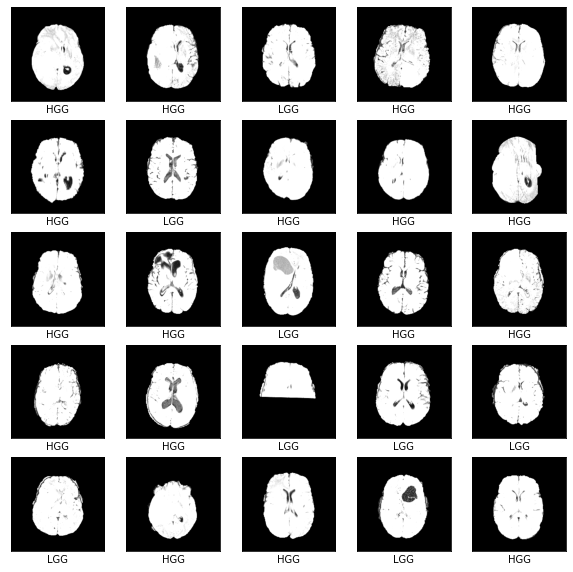

In [12]:
plt.set_cmap('gray')
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel('LGG' if y_train[i] == 0 else 'HGG')
plt.show()

In [117]:
x_train.shape

(183, 240, 240)

## 2.2 Reshape to have one channel

Trevor's model

In [15]:
# model = keras.models.Sequential([keras.layers.Flatten(input_shape = [240, 240]),
#     keras.layers.Dense(300, activation = 'relu' ),
#     keras.layers.Dense(100, activation = 'relu' ),
#     keras.layers.Dense(100, activation = 'relu' ),
#     keras.layers.Dense(100, activation = 'relu' ),
#     keras.layers.Dense(2, activation = 'softmax' )])

In [16]:
x_train_channels = x_train.reshape(-1, 240, 240, 1)
x_test_channels = x_test.reshape(-1, 240, 240, 1)

In [17]:
%load_ext tensorboard

In [111]:
model = keras.models.Sequential([
    keras.layers.Conv2D(48, (7, 7), strides = (2, 2), activation='relu', input_shape=(240, 240, 1), data_format='channels_last', name = 'conv0'),
    keras.layers.MaxPooling2D((2, 2), name='max_pool0'),
    keras.layers.BatchNormalization(name = 'bn0'),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')])

In [112]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 117, 117, 48)      2400      
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 58, 58, 48)        0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 58, 58, 48)        192       
_________________________________________________________________
flatten_12 (Flatten)         (None, 161472)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 161473    
Total params: 164,065
Trainable params: 163,969
Non-trainable params: 96
_________________________________________________________________


In [113]:
from sklearn.utils import compute_class_weight
classes = [0,1]
classWeight = compute_class_weight('balanced', classes, y_train) 
classWeight = dict(enumerate(classWeight))

/Users/Vanessa/opt/anaconda3/envs/data598/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0, 1], y=[1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [118]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(loss = 'binary_crossentropy',
             optimizer = opt, metrics = ['binary_accuracy', keras.metrics.AUC()])

In [119]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

neural_net = model.fit(x_train_channels, y_train, batch_size=32, epochs = 20, validation_data = (x_test_channels, y_test), class_weight=classWeight, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 5s 579ms/step - loss: 0.0589 - binary_accuracy: 1.0000 - auc_24: 1.0000 - val_loss: 0.5586 - val_binary_accuracy: 0.8132 - val_auc_24: 0.8577
Epoch 2/20
6/6 [==============================] - 2s 408ms/step - loss: 0.0540 - binary_accuracy: 1.0000 - auc_24: 1.0000 - val_loss: 0.5787 - val_binary_accuracy: 0.8242 - val_auc_24: 0.8584
Epoch 3/20
6/6 [==============================] - 2s 404ms/step - loss: 0.0567 - binary_accuracy: 0.9949 - auc_24: 1.0000 - val_loss: 0.5623 - val_binary_accuracy: 0.8132 - val_auc_24: 0.8573
Epoch 4/20
6/6 [==============================] - 3s 427ms/step - loss: 0.0548 - binary_accuracy: 1.0000 - auc_24: 1.0000 - val_loss: 0.5635 - val_binary_accuracy: 0.8132 - val_auc_24: 0.8554
Epoch 5/20
6/6 [==============================] - 2s 394ms/step - loss: 0.0486 - binary_accuracy: 1.0000 - auc_24: 1.0000 - val_loss: 0.5677 - val_binary_accuracy: 0.8242 - val_auc_24: 0.8581
Epoch 6/20
6/6 [========================

In [116]:
# %reload_ext tensorboard
%tensorboard --logdir {logdir}  --host localhost

In [24]:
sum(y_test)/len(y_test)

0.8021978021978022

In [ ]:
# augment the smaller class?